In [16]:
import pandas as pd

df = pd.read_csv('../../data/pl_final.csv')

In [17]:
df = df.sort_values('date')

df['home_xG_rolling'] = (
    df.groupby('home_team')['xG'].transform(lambda s: s.shift().rolling(5, min_periods=1).mean())
)

df['away_xG_rolling'] = (
    df.groupby('away_team')['xG.1'].transform(lambda s: s.shift().rolling(5, min_periods=1).mean())
)

df['xG_diff_rolling'] = df['home_xG_rolling'] - df['away_xG_rolling']

df['elo_diff'] = df['home_elo_before'] - df['away_elo_before']

df['goals_diff_rolling'] = df['home_goals_scored_rolling'] - df['away_goals_scored_rolling']
df['conceded_diff_rolling'] = df['home_goals_conceded_rolling'] - df['away_goals_conceded_rolling']

In [18]:
df.dropna(inplace=True, axis=0)
df.columns

Index(['date', 'home_team', 'away_team', 'result', 'odds_home_win',
       'odds_draw', 'odds_away_win', 'home_goals_scored_rolling',
       'home_goals_conceded_rolling', 'home_shots_rolling',
       'home_shots_on_target_rolling', 'home_fouls_rolling',
       'home_corners_rolling', 'home_yellow_cards_rolling',
       'home_red_cards_rolling', 'away_goals_scored_rolling',
       'away_goals_conceded_rolling', 'away_shots_rolling',
       'away_shots_on_target_rolling', 'away_fouls_rolling',
       'away_corners_rolling', 'away_yellow_cards_rolling',
       'away_red_cards_rolling', 'home_elo_before', 'away_elo_before',
       'prob_home', 'prob_draw', 'prob_away', 'xG', 'xG.1', 'home_xG_rolling',
       'away_xG_rolling', 'xG_diff_rolling', 'elo_diff', 'goals_diff_rolling',
       'conceded_diff_rolling'],
      dtype='object')

In [19]:
# df = df[df['date'] >= '2025-08-01']

In [20]:
import pandas as pd
import numpy as np

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    log_loss, brier_score_loss, confusion_matrix, classification_report
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import matplotlib.pyplot as plt
import seaborn as sns


In [21]:
df = df.sort_values('date')

In [22]:
X = df.drop(columns=['result', 'date', 'xG', 'xG.1', 'home_red_cards_rolling', 'away_red_cards_rolling', 'home_team', 'away_team'])
y = df['result']

In [23]:
X.columns

Index(['odds_home_win', 'odds_draw', 'odds_away_win',
       'home_goals_scored_rolling', 'home_goals_conceded_rolling',
       'home_shots_rolling', 'home_shots_on_target_rolling',
       'home_fouls_rolling', 'home_corners_rolling',
       'home_yellow_cards_rolling', 'away_goals_scored_rolling',
       'away_goals_conceded_rolling', 'away_shots_rolling',
       'away_shots_on_target_rolling', 'away_fouls_rolling',
       'away_corners_rolling', 'away_yellow_cards_rolling', 'home_elo_before',
       'away_elo_before', 'prob_home', 'prob_draw', 'prob_away',
       'home_xG_rolling', 'away_xG_rolling', 'xG_diff_rolling', 'elo_diff',
       'goals_diff_rolling', 'conceded_diff_rolling'],
      dtype='object')

In [24]:
tscv = TimeSeriesSplit(n_splits=10)
rf_importances = []

In [25]:
def multiclass_brier_score(y_true, y_prob):
    """
    Computes the multiclass Brier score (the mean squared error between
    one-hot labels and predicted probabilities).
    """
    n_classes = y_prob.shape[1]
    y_true_onehot = np.eye(n_classes)[y_true]  # One-hot encode labels
    return np.mean(np.sum((y_prob - y_true_onehot)**2, axis=1)) / n_classes

def evaluate_model(model, X_train, X_test, y_train, y_test, name="Model"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)

    # --- Metrics ---
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, average='weighted', zero_division=0)
    rec = recall_score(y_test, preds, average='weighted', zero_division=0)
    f1 = f1_score(y_test, preds, average='weighted', zero_division=0)
    ll = log_loss(y_test, probs)

    # Correct multiclass Brier score
    brier = multiclass_brier_score(y_test.to_numpy(), probs)


    print(f"\n=== {name} ===")
    print('accuracy:', acc)
    print('precision:', prec)
    print('recall:', rec)
    print('f1 score:', f1)
    print('log loss:', ll)
    print('brier score:', brier)

    # --- Classification Report ---
    print("\nClassification Report:")
    print(classification_report(
        y_test, preds, 
        target_names=["Draw", "Away", "Home"],
        zero_division=0
    ))

    # # --- Confusion Matrix ---
    cm = confusion_matrix(y_test, preds)
    # plt.figure(figsize=(6, 4))
    # sns.heatmap(
    #     cm, annot=True, fmt='d',
    #     xticklabels=["Draw", "Away", "Home"],
    #     yticklabels=["Draw", "Away", "Home"]
    # )
    # plt.title(f"Confusion Matrix: {name}")
    # plt.xlabel("Predicted")
    # plt.ylabel("True")
    # plt.show()

    metrics = {
            "accuracy": acc,
            "precision": prec,
            "recall": rec,
            "f1": f1,
            "log_loss": ll,
            "brier": brier,
            "confusion_matrix": cm
        }
    return metrics

In [26]:
results = {
    "RandomForest": [],
    "XGBoost": [],
    "CatBoost": []
}

rf_importances = []

for fold, (train_idx, test_idx) in enumerate(tscv.split(X)):
    print(f"\n================ FOLD {fold+1} ================")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # --- 1. Random Forest ---
    rf = RandomForestClassifier(
        n_estimators=1500,
        max_depth=12,
        min_samples_split=4,
        random_state=42
    )

    m_rf = evaluate_model(rf, X_train, X_test, y_train, y_test, "Random Forest")
    results["RandomForest"].append(m_rf)
    rf_importances.append(rf.feature_importances_)
    
    # --- 2. XGBoost ---
    xgb = XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        n_estimators=1500,
        learning_rate=0.03,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='mlogloss',
        tree_method='hist'
    )
    m_xgb = evaluate_model(xgb, X_train, X_test, y_train, y_test, "XGBoost")
    results["XGBoost"].append(m_xgb)

    # --- 3. CatBoost ---
    cat = CatBoostClassifier(
        loss_function='MultiClass',
        depth=7,
        iterations=1500,
        learning_rate=0.03,
        verbose=False
    )
    m_cat = evaluate_model(cat, X_train, X_test, y_train, y_test, "CatBoost")
    results["CatBoost"].append(m_cat)



================ FOLD 1 ================

=== Random Forest ===
accuracy: 0.4794520547945205
precision: 0.5103840784277428
recall: 0.4794520547945205
f1 score: 0.491190479142131
log loss: 1.0562003585061064
brier score: 0.207653951194104

Classification Report:
              precision    recall  f1-score   support

        Draw       0.14      0.18      0.15        28
        Away       0.62      0.49      0.55        57
        Home       0.58      0.61      0.59        61

    accuracy                           0.48       146
   macro avg       0.45      0.43      0.43       146
weighted avg       0.51      0.48      0.49       146


=== XGBoost ===
accuracy: 0.4246575342465753
precision: 0.43839832133193474
recall: 0.4246575342465753
f1 score: 0.42540017475994657
log loss: 1.595099465132178
brier score: 0.27439543163977226

Classification Report:
              precision    recall  f1-score   support

        Draw       0.10      0.11      0.10        28
        Away       0.55     

In [27]:
import pandas as pd

def summarize_results(results):
    summary = {}
    for model_name, folds in results.items():
        df = pd.DataFrame(folds)
        avg = df.mean(numeric_only=True)
        summary[model_name] = avg
        print(f"\n====== AVERAGE RESULTS: {model_name} ======")
        print(avg)
    return summary

summary = summarize_results(results)



====== AVERAGE RESULTS: RandomForest ======
accuracy     0.546575
precision    0.468397
recall       0.546575
f1           0.490664
log_loss     0.987087
brier        0.194820
dtype: float64

====== AVERAGE RESULTS: XGBoost ======
accuracy     0.503425
precision    0.468049
recall       0.503425
f1           0.473742
log_loss     1.414385
brier        0.240613
dtype: float64

====== AVERAGE RESULTS: CatBoost ======
accuracy     0.525342
precision    0.483110
recall       0.525342
f1           0.485380
log_loss     1.079289
brier        0.209571
dtype: float64


In [28]:
def average_confusion_matrix(model_name):
    cms = [r["confusion_matrix"] for r in results[model_name]]
    return sum(cms) / len(cms)

avg_cm_rf = average_confusion_matrix("RandomForest")
avg_cm_xgb = average_confusion_matrix("XGBoost")
avg_cm_cat = average_confusion_matrix("CatBoost")


<Figure size 1000x400 with 0 Axes>

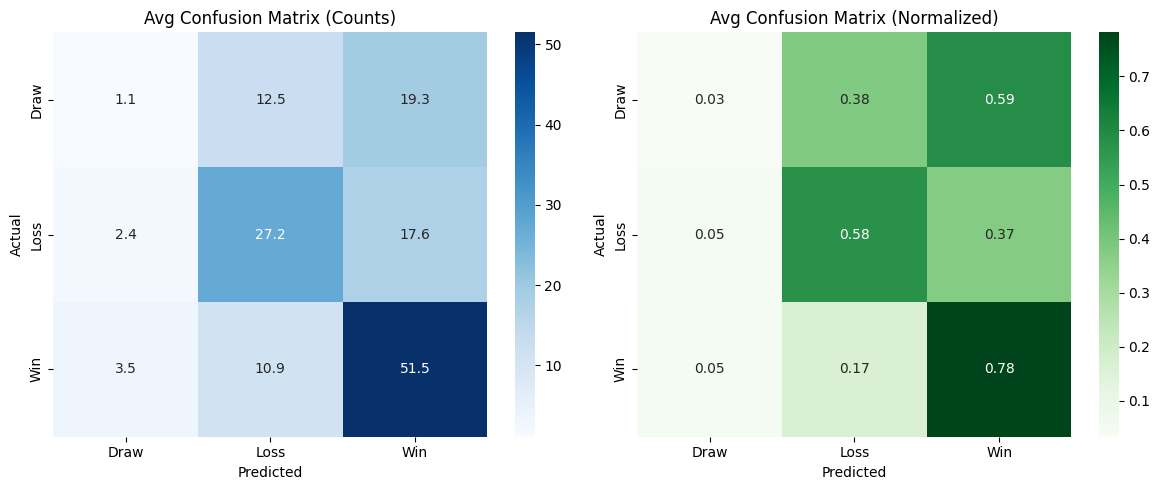

In [37]:
labels = ['Draw', 'Loss', 'Win']
avg_cm_rf_norm = avg_cm_rf / avg_cm_rf.sum(axis=1, keepdims=True)

plt.figure(figsize=(10,4))
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(avg_cm_rf, annot=True, fmt=".1f", cmap="Blues",
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title("Avg Confusion Matrix (Counts)")
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

sns.heatmap(avg_cm_rf_norm, annot=True, fmt=".2f", cmap="Greens",
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title("Avg Confusion Matrix (Normalized)")
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
plt.tight_layout()
plt.show()

In [16]:
# Average across folds
rf_importances = np.array(rf_importances)
avg_importances = rf_importances.mean(axis=0)

# Put in a DataFrame for readability
fi_df = pd.DataFrame({
    "feature": X.columns,
    "importance": avg_importances
}).sort_values("importance", ascending=False)

In [40]:
fi_df

,feature,importance
21,prob_away,0.062625
19,prob_home,0.061945
2,odds_away_win,0.048483
0,odds_home_win,0.046371
25,elo_diff,0.045518
17,home_elo_before,0.042038
12,away_shots_rolling,0.040416
20,prob_draw,0.039858
24,xG_diff_rolling,0.039593
18,away_elo_before,0.038706


C:\Users\emir_\AppData\Local\Temp\ipykernel_10192\622475177.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


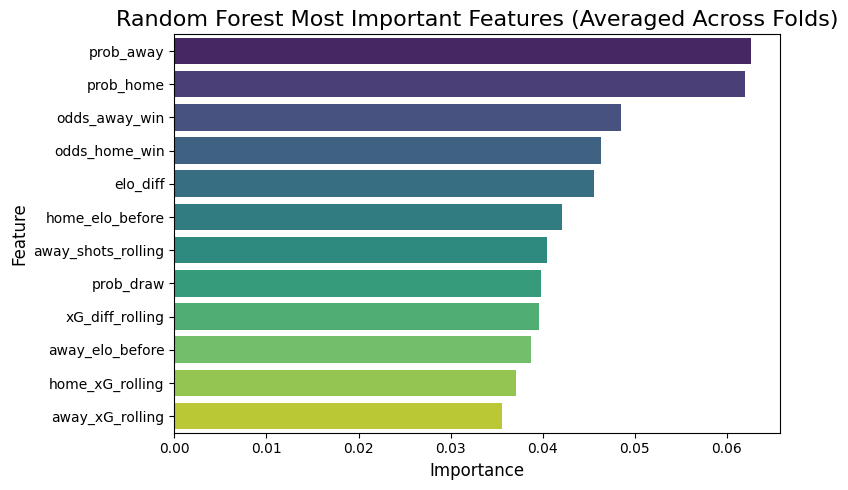

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort values for clearer plotting
fi_sorted = fi_df.sort_values("importance", ascending=False).head(12)

plt.figure(figsize=(8,5))
sns.barplot(
    data=fi_sorted,
    x="importance",
    y="feature",
    palette='viridis'
)

plt.title("Random Forest Most Important Features (Averaged Across Folds)", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()


In [19]:
home_baseline_acc = (y_test == 2).mean()
print(f"Baseline (Always Home Win): {home_baseline_acc:.2f}")


Baseline (Always Home Win): 0.49


In [20]:
most_common = y_train.value_counts().idxmax()
print(most_common)
freq_baseline_acc = (y_test == most_common).mean()
print(f"Baseline (Most Frequent Class = {most_common}): {freq_baseline_acc:.2f}")


2
Baseline (Most Frequent Class = 2): 0.49


In [21]:
results["RandomForest"]

[{'accuracy': 0.4794520547945205,
  'precision': 0.5103840784277428,
  'recall': 0.4794520547945205,
  'f1': 0.491190479142131,
  'log_loss': 1.0562003585061064,
  'brier': np.float64(0.207653951194104)},
 {'accuracy': 0.5753424657534246,
  'precision': 0.4452757288373727,
  'recall': 0.5753424657534246,
  'f1': 0.5019996275884686,
  'log_loss': 0.9505568270302901,
  'brier': np.float64(0.18785221212663075)},
 {'accuracy': 0.4657534246575342,
  'precision': 0.36969879856276666,
  'recall': 0.4657534246575342,
  'f1': 0.4121946546604081,
  'log_loss': 1.0820421720173292,
  'brier': np.float64(0.21509190389157795)},
 {'accuracy': 0.6164383561643836,
  'precision': 0.5762954139368671,
  'recall': 0.6164383561643836,
  'f1': 0.566331406726437,
  'log_loss': 0.9321492251932969,
  'brier': np.float64(0.18336126482778559)},
 {'accuracy': 0.5616438356164384,
  'precision': 0.5377417938255972,
  'recall': 0.5616438356164384,
  'f1': 0.5243588435640517,
  'log_loss': 0.961191820027425,
  'brier'

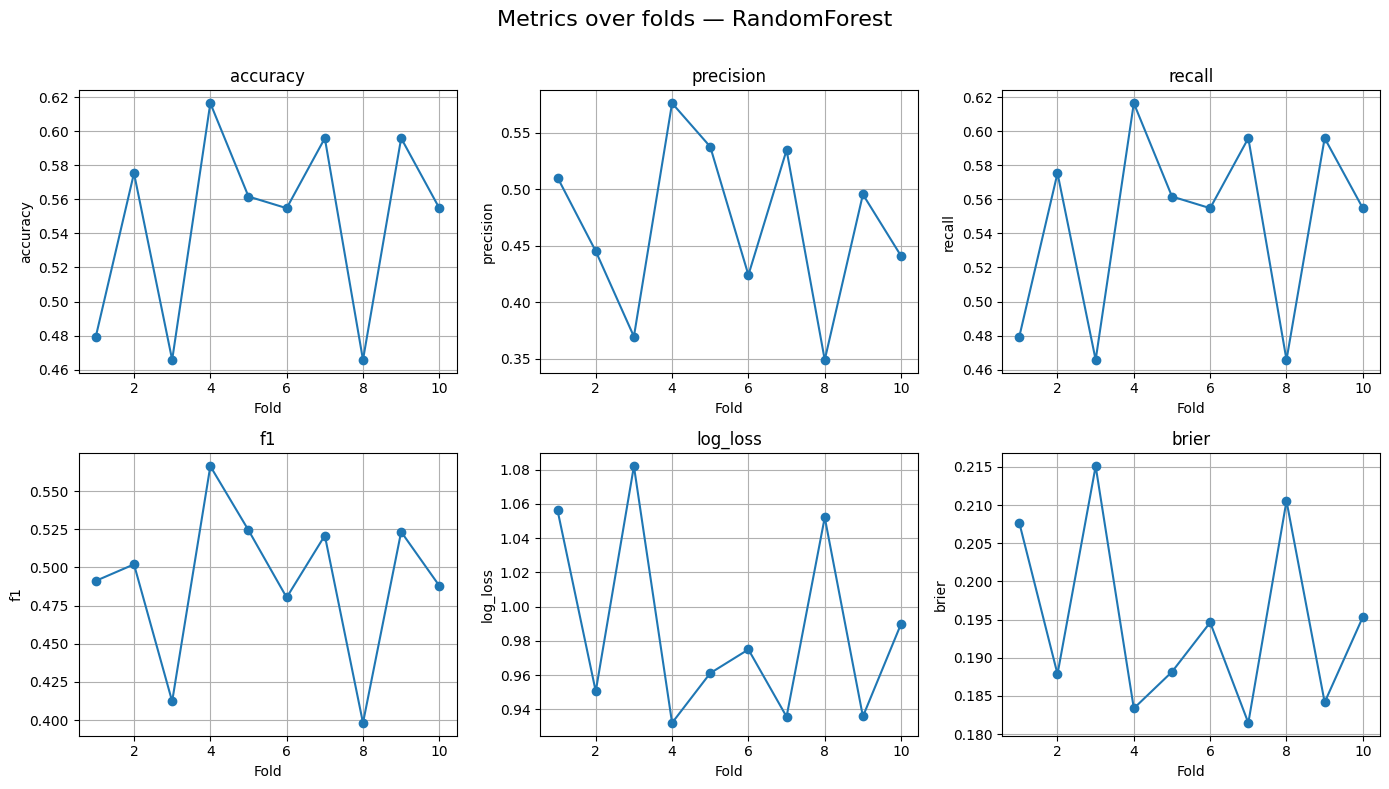

In [22]:
import matplotlib.pyplot as plt

def plot_metrics_over_folds(results_dict, model_name="RandomForest"):
    df = pd.DataFrame(results_dict)
    folds = range(1, len(df) + 1)

    plt.figure(figsize=(14, 8))

    for i, metric in enumerate(df.columns):
        plt.subplot(2, 3, i + 1)
        plt.plot(folds, df[metric], marker='o')
        plt.title(metric)
        plt.xlabel("Fold")
        plt.ylabel(metric)
        plt.grid(True)

    plt.suptitle(f"Metrics over folds — {model_name}", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# Use it:
plot_metrics_over_folds(results["RandomForest"], "RandomForest")


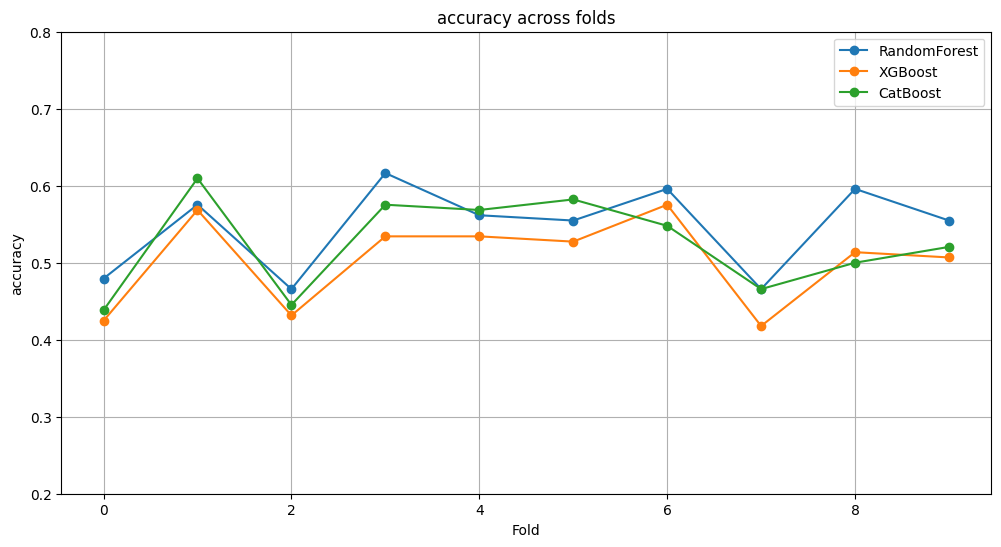

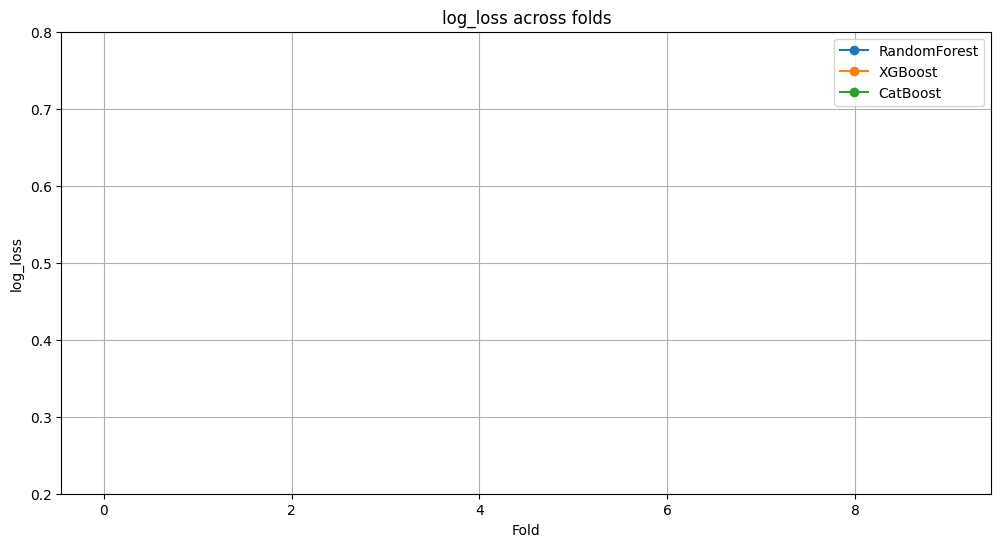

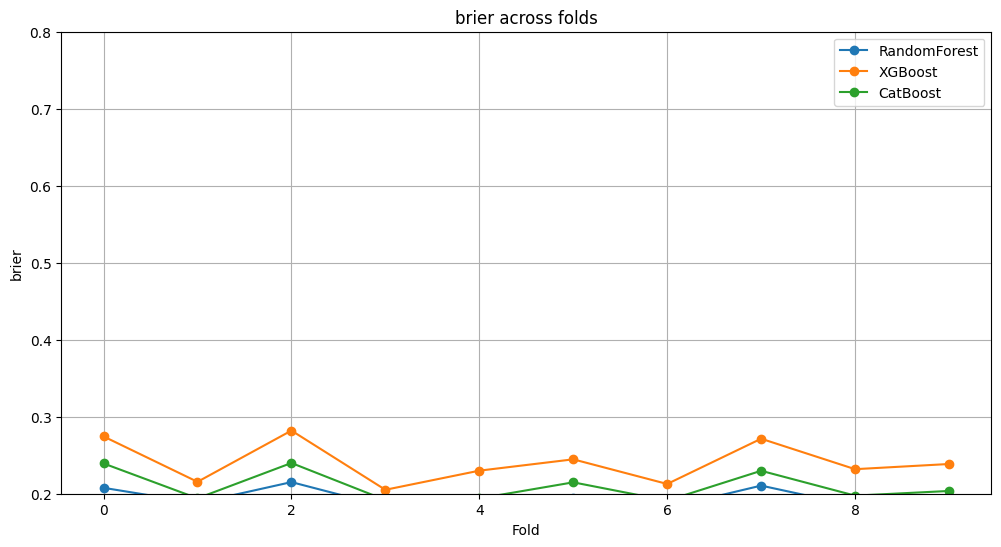

In [45]:
def compare_models_metrics(results, metric):
    plt.figure(figsize=(12,6))

    for model_name, model_results in results.items():
        df = pd.DataFrame(model_results)
        plt.plot(df[metric], marker='o', label=model_name)

    plt.title(f"{metric} across folds")
    plt.ylim(0.2, 0.8)
    plt.xlabel("Fold")
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

compare_models_metrics(results, "accuracy")
compare_models_metrics(results, "log_loss")
compare_models_metrics(results, "brier")


In [24]:
rf = RandomForestClassifier(
    n_estimators=1500,
    max_depth=12,
    min_samples_split=4,
    random_state=42
)

In [25]:
from sklearn.calibration import CalibratedClassifierCV

final_rf = CalibratedClassifierCV(rf, method='isotonic', cv=5)
final_rf.fit(X, y)

,estimator,RandomForestC...ndom_state=42)
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,n_estimators,1500
,criterion,'gini'
,max_depth,12
,min_samples_split,4
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [26]:
# Predictions on training set
train_preds = final_rf.predict(X)

# Training accuracy
train_acc = accuracy_score(y, train_preds)
print("Training accuracy:", train_acc)

train_probs = final_rf.predict_proba(X)

print("Training precision:", precision_score(y, train_preds, average='weighted'))
print("Training recall:", recall_score(y, train_preds, average='weighted'))
print("Training f1:", f1_score(y, train_preds, average='weighted'))
print("Training log loss:", log_loss(y, train_probs))


Training accuracy: 0.9645080946450809
Training precision: 0.9664578449828001
Training recall: 0.9645080946450809
Training f1: 0.9645794114394699
Training log loss: 0.44539006274201026


In [27]:
import joblib
joblib.dump(final_rf, "../../models/random_forest_model.pkl", compress=3)

feature_names = X.columns.tolist()
features_path = '../../models/feature_names.pkl'
joblib.dump(feature_names, features_path, compress=3)

['../../models/feature_names.pkl']

In [28]:
# --- 2. XGBoost ---
xgb = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    n_estimators=1500,
    learning_rate=0.03,
    max_depth=7,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='mlogloss',
    tree_method='hist'
)

# --- 3. CatBoost ---
cat = CatBoostClassifier(
    loss_function='MultiClass',
    depth=7,
    iterations=1500,
    learning_rate=0.03,
    verbose=False
)

In [29]:
final_xgb = CalibratedClassifierCV(xgb, method='isotonic', cv=5)
final_xgb.fit(X, y)

,estimator,"XGBClassifier..._class=3, ...)"
,method,'isotonic'
,cv,5
,n_jobs,None
,ensemble,'auto'
,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [30]:
# Predictions on training set
train_preds = final_xgb.predict(X)

# Training accuracy
train_acc = accuracy_score(y, train_preds)
print("Training accuracy:", train_acc)

train_probs = final_xgb.predict_proba(X)

print("Training precision:", precision_score(y, train_preds, average='weighted'))
print("Training recall:", recall_score(y, train_preds, average='weighted'))
print("Training f1:", f1_score(y, train_preds, average='weighted'))
print("Training log loss:", log_loss(y, train_probs))
joblib.dump(final_xgb, "../../models/xgboost_model.pkl", compress=3)

Training accuracy: 1.0
Training precision: 1.0
Training recall: 1.0
Training f1: 1.0
Training log loss: 0.3562084239808404


['../../models/xgboost_model.pkl']

In [31]:
final_cat = CalibratedClassifierCV(cat, method='isotonic', cv=5)
final_cat.fit(X, y)

KeyboardInterrupt: 

In [ ]:
train_preds = final_cat.predict(X)
train_acc = accuracy_score(y, train_preds)
print("Training accuracy:", train_acc)
train_probs = final_cat.predict_proba(X)
print("Training precision:", precision_score(y, train_preds, average='weighted'))
print("Training recall:", recall_score(y, train_preds, average='weighted'))
print("Training f1:", f1_score(y, train_preds, average='weighted'))
print("Training log loss:", log_loss(y, train_probs))
joblib.dump(final_cat, "../../models/catboost_model.pkl", compress=3)

Training accuracy: 0.9975093399750934
Training precision: 0.9975231386455916
Training recall: 0.9975093399750934
Training f1: 0.9975099074050302
Training log loss: 0.44615372137145354


['../../models/catboost_model.pkl']

In [ ]:
from sklearn.calibration import calibration_curve

def plot_calibration(model, X_test, y_test, class_index, class_name):
    probs = model.predict_proba(X_test)[:, class_index]
    true_labels = (y_test == class_index).astype(int)

    prob_true, prob_pred = calibration_curve(true_labels, probs, n_bins=10)

    plt.plot(prob_pred, prob_true, marker='o')
    plt.plot([0,1], [0,1], linestyle='--')
    plt.title(f"Calibration Curve: {class_name}")
    plt.xlabel("Predicted probability")
    plt.ylabel("True probability")
    plt.show()

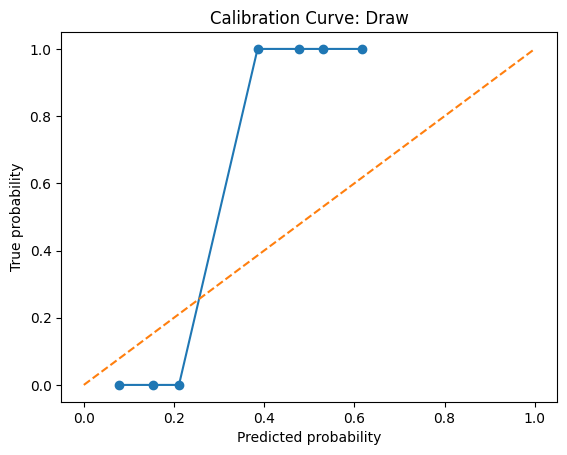

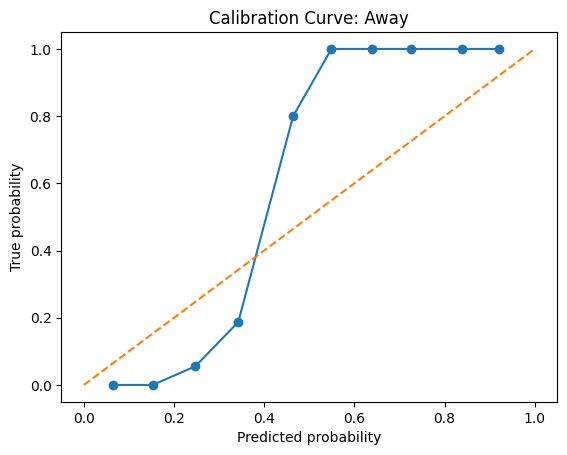

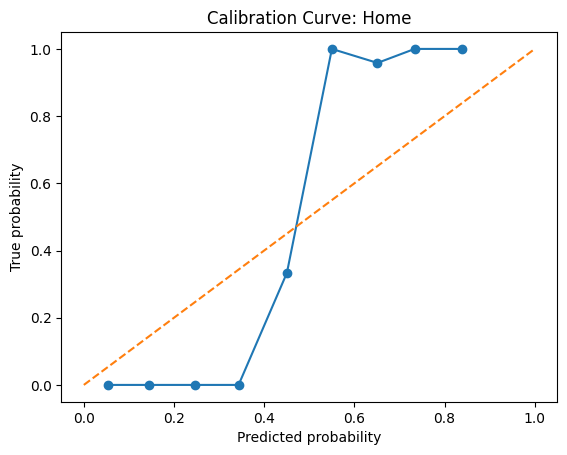

In [ ]:
plot_calibration(final_rf, X_test, y_test, 0, "Draw")
plot_calibration(final_rf, X_test, y_test, 1, "Away")
plot_calibration(final_rf, X_test, y_test, 2, "Home")

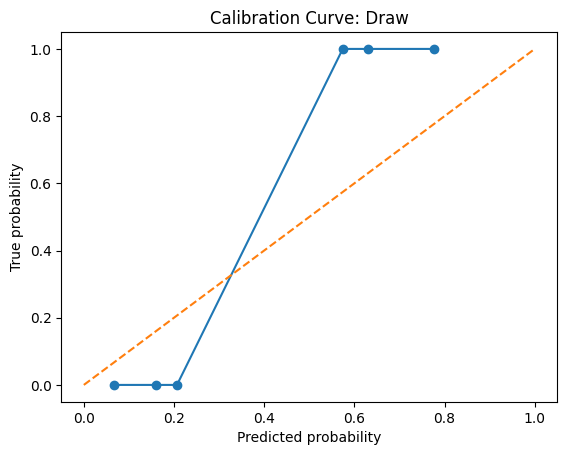

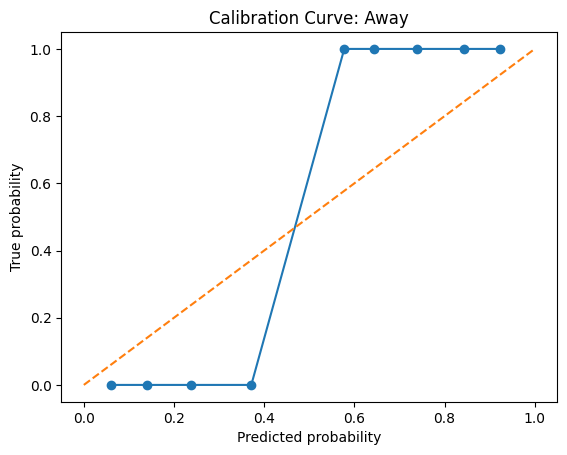

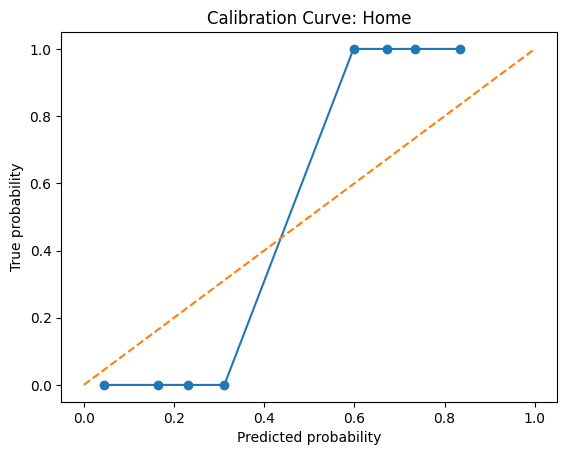

In [ ]:
plot_calibration(final_xgb, X_test, y_test, 0, "Draw")
plot_calibration(final_xgb, X_test, y_test, 1, "Away")
plot_calibration(final_xgb, X_test, y_test, 2, "Home")

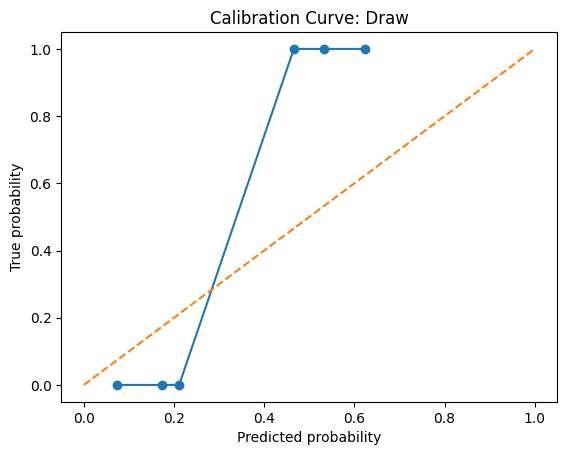

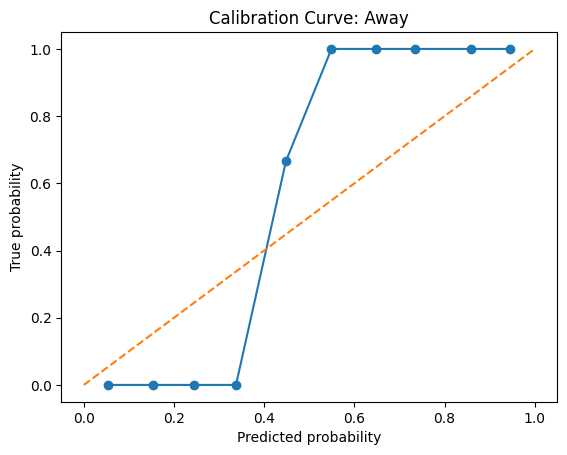

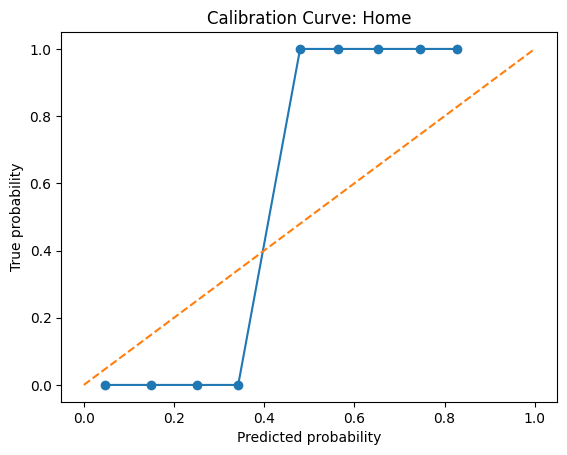

In [ ]:
plot_calibration(final_cat, X_test, y_test, 0, "Draw")
plot_calibration(final_cat, X_test, y_test, 1, "Away")
plot_calibration(final_cat, X_test, y_test, 2, "Home")

C:\Users\emir_\AppData\Local\Temp\ipykernel_5924\205550020.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=result_counts.values , palette='viridis')


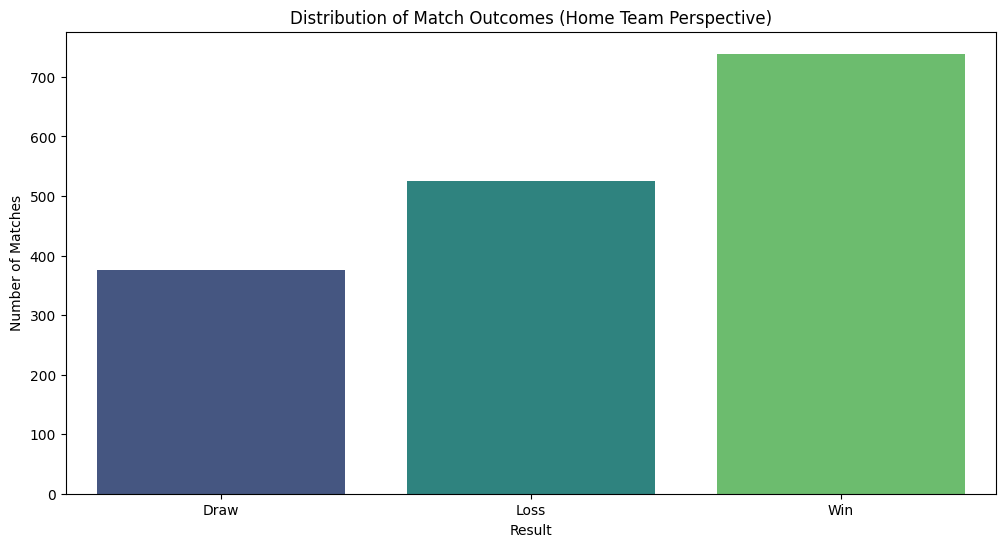

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Value counts
result_counts = df['result'].value_counts().sort_index()
labels = ['Draw', 'Loss', 'Win']

plt.figure(figsize=(12,6))
sns.barplot(x=labels, y=result_counts.values , palette='viridis')
plt.title('Distribution of Match Outcomes (Home Team Perspective)')
plt.xlabel('Result')
plt.ylabel('Number of Matches')
plt.show()


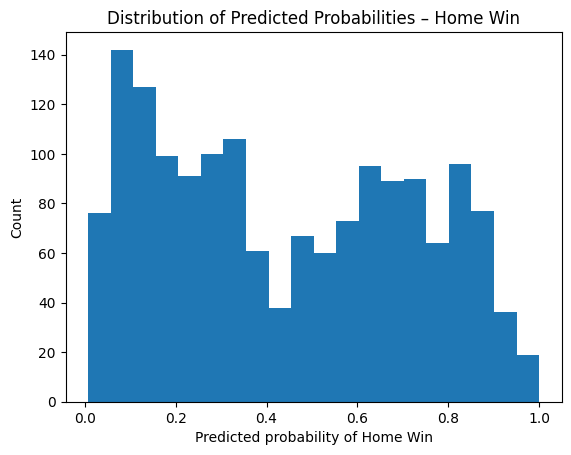

In [10]:
import joblib
rf = joblib.load('../../models/random_forest_model.pkl')

import matplotlib.pyplot as plt

probs = rf.predict_proba(X)[:, 2]   # class index for home win

plt.hist(probs, bins=20)
plt.xlabel("Predicted probability of Home Win")
plt.ylabel("Count")
plt.title("Distribution of Predicted Probabilities – Home Win")
plt.show()



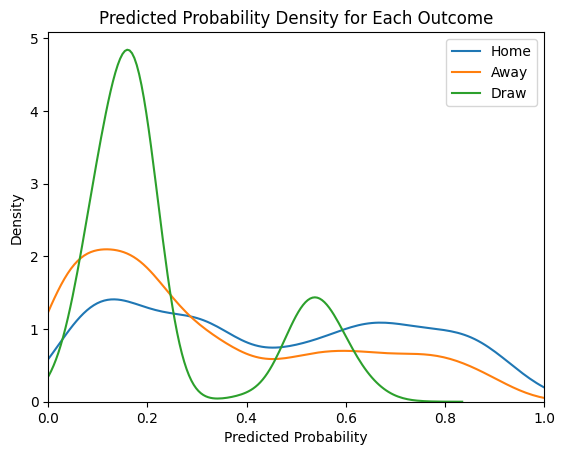

In [15]:
import seaborn as sns
import pandas as pd

probs = rf.predict_proba(X)

df = pd.DataFrame({
    "prob_draw": probs[:, 0],
    "prob_away": probs[:, 1],
    "prob_home": probs[:, 2],
})

sns.kdeplot(df["prob_home"], label="Home")
sns.kdeplot(df["prob_away"], label="Away")
sns.kdeplot(df["prob_draw"], label="Draw")
plt.title("Predicted Probability Density for Each Outcome")
plt.xlim(0, 1)
plt.xlabel("Predicted Probability")
plt.legend()
plt.show()


Note: you may need to restart the kernel to use updated packages.


c:\Users\emir_\anaconda3\envs\datascience\Lib\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


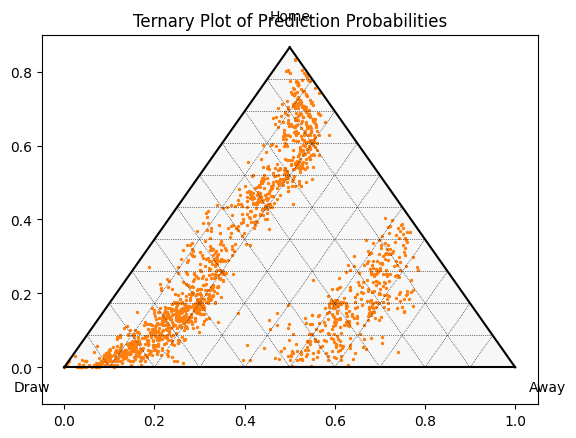

In [14]:
%pip install python-ternary
import ternary

figure, tax = ternary.figure(scale=1)
tax.boundary()
tax.gridlines(color="black", multiple=0.1)

points = list(map(tuple, probs))
tax.scatter(points, s=2)

tax.left_corner_label("Draw")
tax.right_corner_label("Away")
tax.top_corner_label("Home")
tax.set_title("Ternary Plot of Prediction Probabilities")

plt.show()
